# Adding star noise to the regression model

In [1]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import jaccard_score

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [4]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy_bg = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)


In [5]:
def star_noise(mean, std):
    chunk_tot = 100
    data_star = np.zeros((64*chunk_tot, 56, 56))
    loc_random_x = np.random.randint(1, high=54, size=64*chunk_tot, dtype=int)
    loc_random_y = np.random.randint(1, high=54, size=64*chunk_tot, dtype=int)
    indices = np.arange(64 * chunk_tot)
    
    for x_i in range(0,3):
        for y_i in range(0,3):
            data_star[indices, loc_random_x+x_i, loc_random_y+y_i] = np.random.normal(loc=20, scale=1, size=(64*chunk_tot))
    
    return data_star

In [6]:
nan_mask = np.isnan(data_noisy_bg[0])
data_star = star_noise(100, 5)*(~nan_mask)

In [7]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

data_noisy_nonan = np.nan_to_num(data_noisy_bg)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy_bg, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

In [8]:
def add_noise(star_mean):
    # Now with a minimum of 0

    nan_mask = np.isnan(data_noisy_bg[0])
    data_noisy_bg_nonan = np.nan_to_num(data_noisy_bg)
    data_true_nonan = np.nan_to_num(data_true)

    # Look at the sum of all the pixels for the noisy and true images

    images_noisy_bg_sum = np.nansum(data_noisy_bg, axis=(1,2))
    images_true_sum = np.nansum(data_true, axis=(1,2))

    images_high_mask = (images_noisy_bg_sum>60)

    # Look at the true images only with pixels of 0 and 1 (non-signal and signal)
    # For the purpose of the classification

    threshold = 0

    data_true_nonan_flat = data_true_nonan.reshape((64*chunk_tot, 56*56))

    # Putting them to the right form with normalization
    data_noisy_bg_arr = data_noisy_bg[images_high_mask]
    data_noisy_bg_arr[np.nan_to_num(data_noisy_bg_arr)<0] = 0


    pix_max_noisy = np.nanmax(data_noisy_bg_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
    data_noisy_bg_norm = np.nan_to_num(data_noisy_bg_arr/pix_max_noisy)
    data_noisy_bg_tensor = (torch.from_numpy(data_noisy_bg_norm).float())


    # Now normalize the true data in the same way as the noisy data

    data_true_arr = data_true_nonan_flat[images_high_mask]
    pix_max_true = np.nanmax(data_noisy_bg_arr, axis=(1,2))[:, np.newaxis]
    data_true_norm = np.nan_to_num(data_true_arr/pix_max_true)
    data_true_tensor = (torch.from_numpy(data_true_norm).float())

    #data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()

    #data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

    # Split train and test

    N, w, h = data_noisy_bg_tensor.shape
    idx_split = int(N*0.8) # 80% training, 20% testing
    data_noisy_bg_train = data_noisy_bg_tensor[:idx_split]
    data_true_train = data_true_tensor[:idx_split]
    data_noisy_bg_test = data_noisy_bg_tensor[idx_split:]
    data_true_test = data_true_tensor[idx_split:]
    
    data_star = star_noise(star_mean, star_mean/20)*(~nan_mask)
    data_star_tensor = (torch.from_numpy((data_star)[images_high_mask])).float() / pix_max_noisy   

    data_star_train = data_star_tensor[:idx_split]
    data_star_test = data_star_tensor[idx_split:]
    
    data_noisy_train = data_noisy_bg_train + data_star_train
    data_noisy_test = data_noisy_bg_test + data_star_test

    
    
    return data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_star_train, data_star_test, idx_split




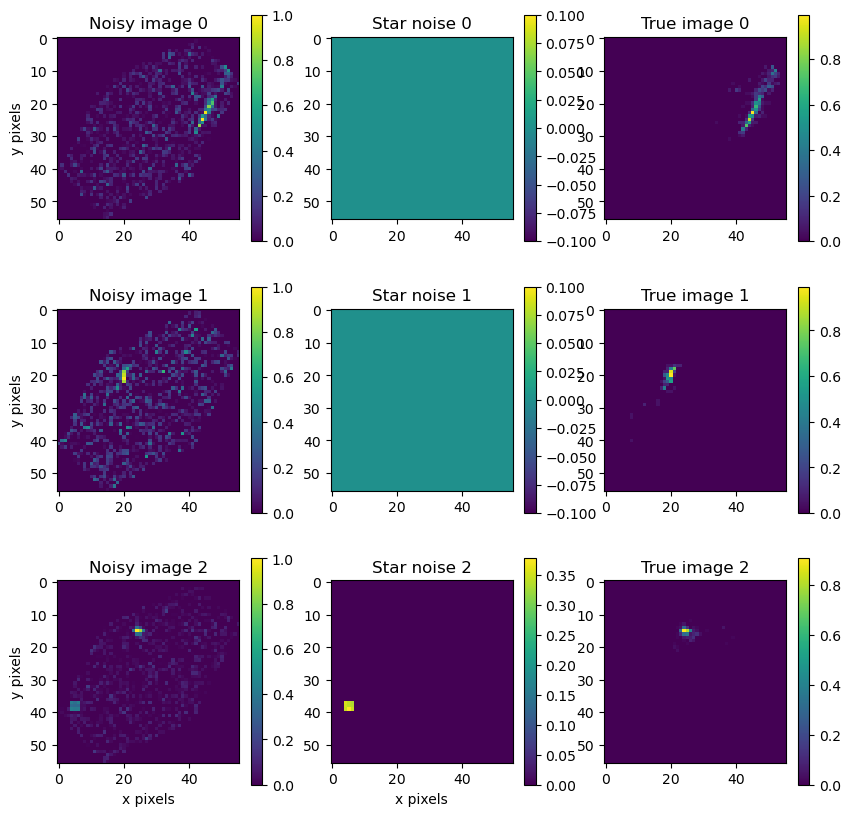

In [9]:
data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_star_train, data_star_test, idx_split = add_noise(20)

n_start = 6
n_images = 3 # Compare 3 examples

fig, axs = plt.subplots(n_images, 3, figsize=(10,10))

for i in range(0,n_images):
    vmax = np.nanmax(data_noisy_test[i])
    
    im_noisy = axs[i,0].imshow(data_noisy_test[i], vmin=0)#, vmax=vmax*1.1)
    axs[i,0].set_title(f"Noisy image {i}")
    axs[i,0].set_ylabel("y pixels")
    plt.colorbar(im_noisy, ax=axs[i,0])
    
    im_true = axs[i,1].imshow(data_star_test[i], vmin=0)#, vmax=vmax*1.1)
    axs[i,1].set_title(f"Star noise {i}")
    plt.colorbar(im_true, ax=axs[i,1])    
    
    im_true = axs[i,2].imshow(data_true_test[i].reshape(56,56), vmin=0)#, vmax=vmax*1.1)
    axs[i,2].set_title(f"True image {i}")
    plt.colorbar(im_true, ax=axs[i,2])
    
    
axs[i,0].set_xlabel("x pixels")
axs[i,1].set_xlabel("x pixels")


plt.show()

**The AE Model**

In [10]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(2, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

**Fitting functions**

In [11]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []

batch_size=1
weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    #random_indices = torch.randperm(len(data_noisy_train))
    random_indices = torch.randperm(4457)
    #print(random_indices.shape)
    data_noisy_train_clone = torch.clone(data_noisy_train)
    #print(data_noisy_train.shape)
    data_true_train_clone = torch.clone(data_true_train)
    data_star_train_clone = torch.clone(data_star_train)
    
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    data_star_train[random_indices] = data_star_train_clone
    
    for noisy_bg, star, true in zip(data_noisy_train, data_star_train, data_true_train):
        noisy = np.zeros((2,56,56))
        noisy[0,:,:] = noisy_bg.reshape(56,56)
        noisy[1,:,:] = star.reshape(56,56)
        noisy = torch.from_numpy(noisy).float()
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.mse_loss(output, true)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.6f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy_bg, star, true in zip(data_noisy_test, data_star_test, data_true_test):
            noisy = np.zeros((2,56,56))
            noisy[0,:,:] = noisy_bg.reshape(56,56)
            noisy[1,:,:] = star.reshape(56,56)
            noisy = torch.from_numpy(noisy).float()
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.mse_loss(output, true)
            test_loss += loss.item()
    
    test_loss /= len(data_noisy_test)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.6f}'.format(test_loss))

In [12]:
%%time

n_epochs = 30

learning_rate = 0.0005

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_star_train, data_star_test, idx_split = add_noise(20)


test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
    
    


Test set: Avg. loss: 0.010005
Training set: Avg. loss: 0.000417

Test set: Avg. loss: 0.000268
Training set: Avg. loss: 0.000263

Test set: Avg. loss: 0.000235
Training set: Avg. loss: 0.000237

Test set: Avg. loss: 0.000204
Training set: Avg. loss: 0.000223

Test set: Avg. loss: 0.000200
Training set: Avg. loss: 0.000209

Test set: Avg. loss: 0.000196
Training set: Avg. loss: 0.000199

Test set: Avg. loss: 0.000186
Training set: Avg. loss: 0.000193

Test set: Avg. loss: 0.000202
Training set: Avg. loss: 0.000189

Test set: Avg. loss: 0.000180
Training set: Avg. loss: 0.000184

Test set: Avg. loss: 0.000184
Training set: Avg. loss: 0.000179

Test set: Avg. loss: 0.000181
Training set: Avg. loss: 0.000175

Test set: Avg. loss: 0.000180
Training set: Avg. loss: 0.000172

Test set: Avg. loss: 0.000182
Training set: Avg. loss: 0.000168

Test set: Avg. loss: 0.000179
Training set: Avg. loss: 0.000165

Test set: Avg. loss: 0.000183
Training set: Avg. loss: 0.000163

Test set: Avg. loss: 0.0

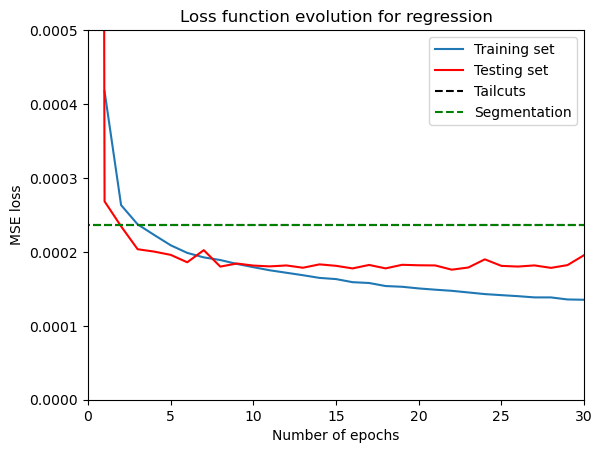

In [14]:
plt.figure()

plt.title("Loss function evolution for regression")
plt.plot(train_counter, train_losses, label='Training set')
plt.plot(test_counter, test_losses, color='red', label='Testing set')
plt.xlabel("Number of epochs")
plt.ylabel("MSE loss")
plt.xlim(0,30)
plt.ylim(0,0.0005)
#plt.hlines(0.000177, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
#plt.hlines(0.000141, -1, n_epochs+1, color='green', linestyles='--', label='Segmentation')
# Only divided by pixmax
plt.hlines(0.00023664429947151884, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
plt.hlines(0.0002363444978731545, -1, n_epochs+1, color='green', linestyles='--', label='Segmentation')
plt.legend()

plt.show()

In [16]:
print(test_losses)

[0.010005410127508801, 0.00026835220159974256, 0.0002345769563635666, 0.00020358748236426252, 0.0002003744580338105, 0.00019596592465765625, 0.00018593516989463677, 0.00020234112036363546, 0.00018009003096401994, 0.00018426588233650377, 0.00018146594646356132, 0.00018039010854963513, 0.00018164777252769606, 0.0001785555474731815, 0.0001830997445824421, 0.00018114258976192974, 0.0001776428549550017, 0.00018230994202666698, 0.00017768184823768277, 0.00018252755445805042, 0.00018187743744501572, 0.00018166027864511883, 0.00017593475464929375, 0.00017886386184495128, 0.00018992797900994898, 0.0001810826072702315, 0.00018014076488077077, 0.00018169605475057554, 0.00017838079312718641, 0.0001821085242794032, 0.00019553648644391757]


**Test for multiple mean values**

In [17]:
%%time

star_means = np.array([0,20,40,60,80,100])
#star_means = np.array([20,100])
n_epochs = 30
learning_rate = 0.0001

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)

train_losses_all = []
test_losses_all = []

for star_mean in star_means:
    print(f'/nstar noise {star_mean}')
    network = AE4()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []
    IOU_list = []

    data_noisy_train, data_true_train, data_noisy_test, data_true_test, data_star_train, data_star_test, idx_split = add_noise(star_mean)

    test()
    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()
        
    data_star_train = 0
    data_star_test = 0
    data_noisy_train = 0
    data_noisy_test = 0
        
    train_losses_all.append(train_losses)
    test_losses_all.append(test_losses)
    
train_losses_arr = np.array(train_losses_all)
test_losses_arr = np.array(test_losses_all)   

/nstar noise 0

Test set: Avg. loss: 0.100747
Training set: Avg. loss: 0.001480

Test set: Avg. loss: 0.000370
Training set: Avg. loss: 0.000343

Test set: Avg. loss: 0.000280
Training set: Avg. loss: 0.000287

Test set: Avg. loss: 0.000261
Training set: Avg. loss: 0.000260

Test set: Avg. loss: 0.000268
Training set: Avg. loss: 0.000241

Test set: Avg. loss: 0.000218
Training set: Avg. loss: 0.000229

Test set: Avg. loss: 0.000219
Training set: Avg. loss: 0.000219

Test set: Avg. loss: 0.000231
Training set: Avg. loss: 0.000213

Test set: Avg. loss: 0.000198
Training set: Avg. loss: 0.000206

Test set: Avg. loss: 0.000200
Training set: Avg. loss: 0.000199

Test set: Avg. loss: 0.000195
Training set: Avg. loss: 0.000195

Test set: Avg. loss: 0.000187
Training set: Avg. loss: 0.000190

Test set: Avg. loss: 0.000187
Training set: Avg. loss: 0.000186

Test set: Avg. loss: 0.000190
Training set: Avg. loss: 0.000181

Test set: Avg. loss: 0.000190
Training set: Avg. loss: 0.000178

Test set:

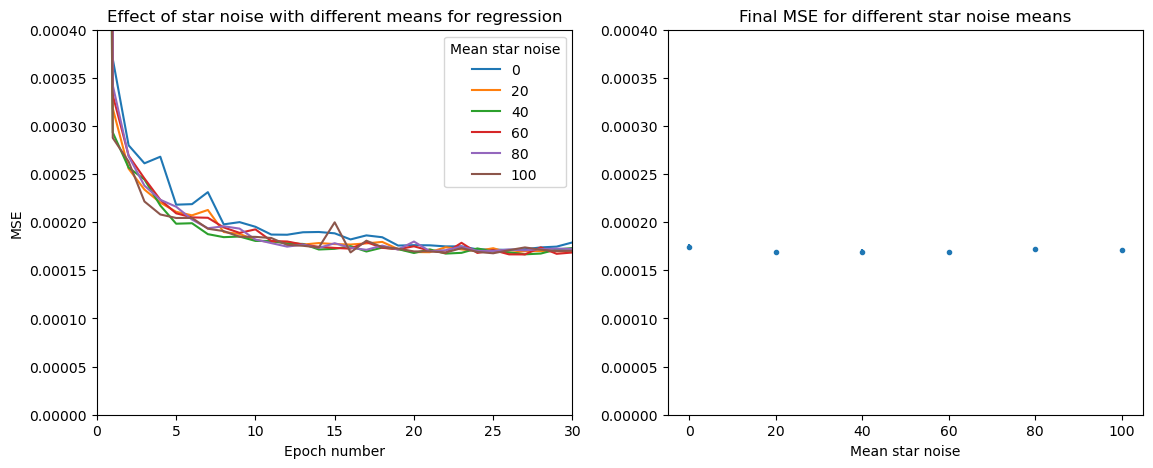

In [21]:
fig_star_noises, axs = plt.subplots(1,2,figsize=(13.5,5))

i=0
for star_mean in star_means:
    axs[0].plot(np.arange(0, n_epochs+1, 1), test_losses_arr[i], label=star_mean)
    
    i=i+1

axs[0].legend(title='Mean star noise')
axs[0].set_xlabel("Epoch number")
axs[0].set_ylabel("MSE")
axs[0].set_ylim(0,0.0004)
axs[0].set_xlim(0,30)
axs[0].set_title("Effect of star noise with different means for regression")

axs[1].errorbar(star_means, np.mean(test_losses_arr[:, -5:], axis=1), yerr=np.std(test_losses_arr[:, -5:], axis=1), fmt='.')
axs[1].set_xlabel("Mean star noise")
axs[1].set_title("Final MSE for different star noise means")
axs[1].set_ylim(0,0.0004)

plt.show()
fig_star_noises.savefig("images/StarNoises.pdf")